<a href="https://colab.research.google.com/github/litvingil/BrainSight-Leveraging-Vision-Transformers-for-Tumor-Detection/blob/main/BrainSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# seed = 1234567
seed = 9921378
output_vit_no_aug = '/content/drive/MyDrive/colab_files/final_deep_project/vit_no_aug'
output_vit_no_aug2 = '/content/drive/MyDrive/colab_files/final_deep_project/vit_no_aug2'
output_vit_no_aug3 = '/content/drive/MyDrive/colab_files/final_deep_project/vit_no_aug3'
output_vit_with_aug = '/content/drive/MyDrive/colab_files/final_deep_project/vit_with_aug'
output_cnn_no_aug = '/content/drive/MyDrive/colab_files/final_deep_project/cnn_no_aug'
output_cnn_with_aug = '/content/drive/MyDrive/colab_files/final_deep_project/cnn_with_aug'
data_path = '/content/drive/MyDrive/colab_files/final_deep_project/data'

In [3]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install wandb

!pip install imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ..

# Load the dataset

In [ ]:
import os
import numpy as np

# Create the required directories
os.makedirs(data_path + '/brain_tumor_dataset', exist_ok=True)
os.makedirs(data_path + '/brain_dataset/train', exist_ok=True)
os.makedirs(data_path +'/brain_dataset/test', exist_ok=True)

# Names of tumor types
tumor_types = ['meningioma','glioma','pituitary tumor']

# Create directories for each tumor type in both train and test sets
for tumor_type in tumor_types:
  os.makedirs(data_path + f'/brain_dataset/test/{tumor_type}', exist_ok=True)
  os.makedirs(data_path + f'/brain_dataset/train/{tumor_type}', exist_ok=True)

# Install necessary Python libraries
!pip install hdf5storage


# Change directory
%cd $data_path'/brain_tumor_dataset'

# Download the dataset
!wget https://ndownloader.figshare.com/articles/1512427/versions/5

# Unzip the dataset and delete the zip
!unzip 5 && rm 5

# Concatenate the multiple zipped data in a single zip
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip

# Remove the temporary files
!rm brainTumorDataPublic_*

# Unzip the full archive and delete it
!unzip data.zip -d data && rm data.zip

# Check that "data" contains 3064 files
!ls data | wc -l

# Change directory to previous
%cd ..

# Clone the GitHub repository containing the script for converting the MATLAB files to NumPy
!git clone https://github.com/guillaumefrd/brain-tumor-mri-dataset.git
!cp brain-tumor-mri-dataset/matlab_to_numpy.py $data_path

# Run the Python script to convert the MATLAB files to NumPy
!python $data_path'/matlab_to_numpy.py' $data_path'/brain_tumor_dataset'

In [ ]:
# Load labels, images, and masks
%cd $data_path'/brain_tumor_dataset'

labels = np.load('labels.npy') - 1  # Subtracting 1 from labels to make them 0-indexed
images = np.load('images.npy')
masks = np.load('masks.npy')

/content/drive/MyDrive/colab_files/final_deep_project/data/brain_tumor_dataset


In [ ]:
from PIL import Image
# Normalize images and convert to PIL format
def normalize_and_convert_images_to_pil(images):
  normalized_pil_images = []
  for image in images:
    normalized_image = (image - np.min(image)) * (255.0 / (np.max(image) - np.min(image)))
    normalized_pil_images.append(Image.fromarray(normalized_image.astype(np.uint8)).convert('RGB'))
  return normalized_pil_images

In [ ]:
# Split the dataset into train and test
train_test_split_ratio = 0.8
num_samples = labels.shape[0]
indices = np.random.RandomState(seed).permutation(num_samples)
train_indices = indices[:int(num_samples * train_test_split_ratio)]
test_indices = indices[int(num_samples * train_test_split_ratio):]

In [ ]:
# Convert images to PIL format
pil_images = normalize_and_convert_images_to_pil(images)

In [ ]:
# Save images to respective directories
index_to_tumor_type = {i: tumor_type for i, tumor_type in enumerate(tumor_types)}
for train_index in train_indices:
  pil_images[train_index].save(data_path + f'/brain_dataset/train/{index_to_tumor_type[labels[train_index]]}/{train_index}.png')
for test_index in test_indices:
  pil_images[test_index].save(data_path + f'/brain_dataset/test/{index_to_tumor_type[labels[test_index]]}/{test_index}.png')

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from datasets import load_dataset, load_metric

from transformers import TrainingArguments, ViTFeatureExtractor, ViTForImageClassification, Trainer

import wandb

# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Lambda
from torchvision.datasets import ImageFolder
from datasets import load_metric
from transformers import TrainingArguments, Trainer, ViTForImageClassification, ViTFeatureExtractor
from accelerate import Accelerator
import imgaug.augmenters as iaa


In [5]:
labels_names = ['meningioma','glioma','pituitary tumor']

# Helper Functions

In [6]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-6-25e90a6ff46d>:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [7]:
#confusion matrix functions
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import metrics as met

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    cm = confusion_matrix(p.label_ids, preds)
    return cm

def print_confusion_matrix(cm, labels_names):
    df_cm = pd.DataFrame(cm, index=labels_names, columns=labels_names)
    print(df_cm)


# ViT


## Transforms

In [ ]:
# Define the augmentation pipeline with imgaug
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip with probability of 0.5
    iaa.Sometimes(0.3, iaa.GaussianBlur((0, 1.0))),  # apply Gaussian blur with probability of 0.3
    iaa.Sometimes(0.5, iaa.SaltAndPepper(0.05)),  # Add Salt and Pepper noise with probability of 0.5
    iaa.Sometimes(0.3, iaa.AdditivePoissonNoise(lam=(0, 30))),  # Add Poisson noise with probability of 0.3
])

# imgaug works with numpy images (HWC) but torchvision with PIL images, so we have to convert
imgaug_transform = Lambda(lambda img: augmenter.augment_image(np.array(img)))

In [ ]:
# Define transformations for the train dataset (without augmentation)
train_transforms_without_aug = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

# Define transformations for the train dataset (including augmentation)
train_transforms_with_aug = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    imgaug_transform,
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

# Define transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

## Without augmentation

In [ ]:
ViT_base = 'google/vit-base-patch16-224-in21k'

# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_without_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms)

In [ ]:
# define the model
def model_init():
  return ViTForImageClassification.from_pretrained(
    ViT_base,
    num_labels=len(labels_names),
    id2label={str(i): tumor_type for i, tumor_type in enumerate(labels_names)},
    label2id={tumor_type: i for i, tumor_type in enumerate(labels_names)},
)

model = model_init()

# Initialize a new run
wandb.init(project="vit_no_aug")

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_vit_no_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: l

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#final
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb.finish()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-p

Step,Training Loss,Validation Loss,Accuracy
50,0.208500,0.362267,0.872757
100,0.173500,0.135880,0.949429
150,0.123100,0.141044,0.952692
200,0.076000,0.142741,0.947798
250,0.100600,0.249677,0.941272
300,0.086400,0.120581,0.964111
350,0.070100,0.150766,0.955954
400,0.056400,0.152167,0.960848
450,0.032600,0.143290,0.962480
500,0.004700,0.135229,0.967374


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 884451758GF
  train_loss               =      0.0985
  train_runtime            =  0:17:38.38
  train_samples_per_second =      11.579
  train_steps_per_second   =       0.728


eval/accuracy,▁▆▇▆▆▇▇▇▇██████
eval/loss,█▂▂▂▅▁▂▂▂▂▂▁▂▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁██████████████
eval/steps_per_second,▁██████████████
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▆▄▃▂▂▂▂▃▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


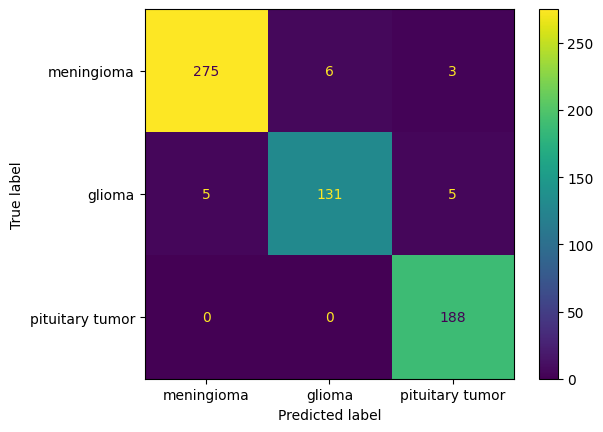

In [ ]:
#display Confusion Matrix
pred = trainer.predict(test_dataset)

cm_display = met.ConfusionMatrixDisplay(confusion_matrix = compute_metrics(pred), display_labels = labels_names)

cm_display.plot()
plt.show()


## With augmentation

In [ ]:
ViT_base = 'google/vit-base-patch16-224-in21k'

# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_with_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms)

In [ ]:
# define the model
model = ViTForImageClassification.from_pretrained(
    ViT_base,
    num_labels=len(labels_names),
    id2label={str(i): c for i, c in enumerate(labels_names)},
    label2id={c: str(i) for i, c in enumerate(labels_names)}
)

# Initialize a new run
wandb.init(project="vit_with_aug")

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_vit_with_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb.finish()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.349200,0.279296,0.913540
100,0.283300,0.200849,0.929853
150,0.303900,0.235043,0.929853
200,0.166300,0.137872,0.959217
250,0.174900,0.143445,0.955954
300,0.112500,0.131100,0.957586
350,0.087700,0.138253,0.959217
400,0.154600,0.116634,0.960848
450,0.084500,0.106484,0.964111
500,0.057300,0.093910,0.965742


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 884451758GF
  train_loss               =      0.1763
  train_runtime            =  0:06:15.88
  train_samples_per_second =      32.603
  train_steps_per_second   =       2.048


eval/accuracy,▁▃▃▆▆▆▆▇▇▇█████
eval/loss,█▅▆▃▃▂▃▂▂▁▁▁▁▁▁
eval/runtime,▄▂▃▃█▁▂▃▂▂▃▂▂▃▄
eval/samples_per_second,▅▆▅▅▁█▇▆▇▇▆▇▇▆▅
eval/steps_per_second,▅▆▅▅▁█▇▆▇▇▆▇▇▆▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▆▄▄▃▃▃▃▄▃▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


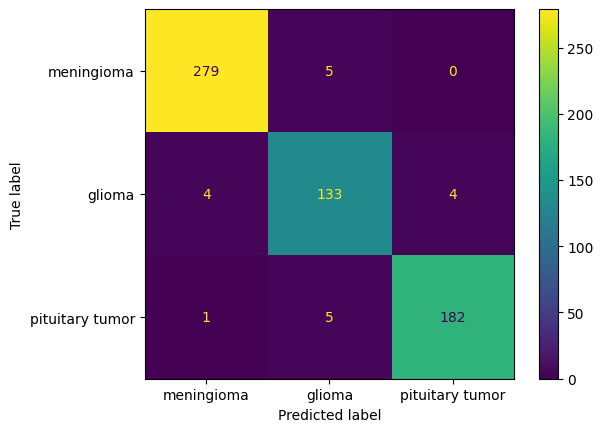

In [ ]:
#display Confusion Matrix
pred = trainer.predict(test_dataset)

cm_display = met.ConfusionMatrixDisplay(confusion_matrix = compute_metrics(pred), display_labels = labels_names)

cm_display.plot()
plt.show()


## Load pretrain


In [ ]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained('/content/drive/MyDrive/colab_files/brain_tumor_dataset/vit-model')

# CNN


## Transforms

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define the augmentation pipeline with imgaug
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip with probability of 0.5
    iaa.Sometimes(0.3, iaa.GaussianBlur((0, 1.0))),  # apply Gaussian blur with probability of 0.3
    iaa.Sometimes(0.5, iaa.SaltAndPepper(0.05)),  # Add Salt and Pepper noise with probability of 0.5
    iaa.Sometimes(0.3, iaa.AdditivePoissonNoise(lam=(0, 30))),  # Add Poisson noise with probability of 0.3
])

# imgaug works with numpy images (HWC) but torchvision with PIL images, so we have to convert
imgaug_transform = Lambda(lambda img: augmenter.augment_image(np.array(img)))

In [ ]:
# Define transformations for the train and test datasets
# Define the cropping percentage
crop_percentage = 0.875

# Define transformations for the train dataset
train_transforms_without_aug = transforms.Compose([
    transforms.CenterCrop((int(512 * crop_percentage),int(512 * crop_percentage))),
    transforms.Resize((224, 224),interpolation=Image.BICUBIC), # Resize 508x508 images to 224x224 using BICUBIC interpolation
    transforms.ToTensor(), # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transformations for the train dataset (including augmentation)
train_transforms_with_aug = transforms.Compose([
    transforms.CenterCrop((int(512 * crop_percentage),int(512 * crop_percentage))),
    transforms.Resize((224, 224),interpolation=Image.BICUBIC), # Resize 508x508 images to 224x224 using BICUBIC interpolation
    imgaug_transform,
    transforms.ToTensor(), # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Define transformations for the test dataset

test_transforms_without_aug = transforms.Compose([
    transforms.CenterCrop((int(512 * crop_percentage),int(512 * crop_percentage))),
    transforms.Resize((224, 224),interpolation=Image.BICUBIC), # Resize 508x508 images to 224x224 using BICUBIC interpolation
    transforms.ToTensor(), # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## Without augmentation

In [ ]:
CNN_base = 'microsoft/resnet-50'

# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_without_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms_without_aug)

In [ ]:
# define the model
def model_init():
  return ViTForImageClassification.from_pretrained(
    CNN_base,
    num_labels=len(labels_names),
    id2label={str(i): tumor_type for i, tumor_type in enumerate(labels_names)},
    label2id={tumor_type: i for i, tumor_type in enumerate(labels_names)},
)

model = model_init()
# Initialize a new run
wandb.init(project="cnn_no_aug")

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_cnn_no_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5, #4
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)


You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb.finish()

You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

Step,Training Loss,Validation Loss,Accuracy
50,1.099900,1.062076,0.477977
100,0.937000,0.958416,0.492659
150,1.517200,0.978854,0.474715
200,0.887400,0.849945,0.636215
250,0.764900,0.683639,0.699837
300,0.893600,0.734032,0.655791
350,0.603400,0.633767,0.714519
400,0.730500,0.630683,0.722675
450,0.585400,0.671268,0.686786
500,0.549900,0.602359,0.743883


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 884451758GF
  train_loss               =      0.7646
  train_runtime            =  0:05:56.60
  train_samples_per_second =      34.366
  train_steps_per_second   =       2.159


eval/accuracy,▁▁▁▅▆▅▇▇▆▇███▇█
eval/loss,█▇▇▅▃▃▂▂▃▂▁▁▁▃▁
eval/runtime,▆▁▆▂▅▂▂▄▆▃█▁▁▄▅
eval/samples_per_second,▃█▃▇▄▇▇▅▃▆▁█▇▅▄
eval/steps_per_second,▃█▃▇▄▇▇▅▃▆▁█▇▅▄
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▂
train/total_flos,▁
train/train_loss,▁


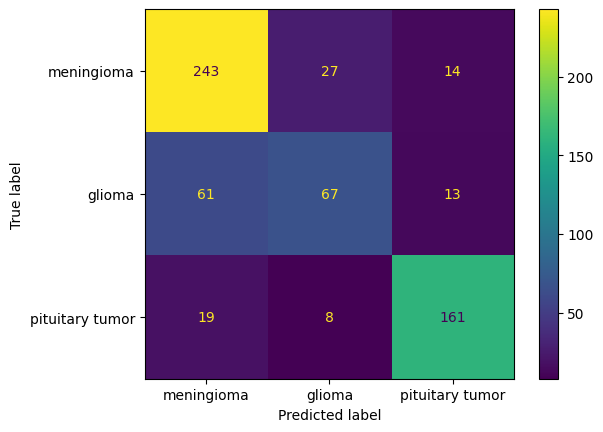

In [ ]:
#display Confusion Matrix
pred = trainer.predict(test_dataset)

cm_display = met.ConfusionMatrixDisplay(confusion_matrix = compute_metrics(pred), display_labels = labels_names)

cm_display.plot()
plt.show()


## With augmentation

In [ ]:
CNN_base = 'microsoft/resnet-50'

# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_with_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms_without_aug)

In [ ]:
# define the model
def model_init():
  return ViTForImageClassification.from_pretrained(
    CNN_base,
    num_labels=len(labels_names),
    id2label={str(i): tumor_type for i, tumor_type in enumerate(labels_names)},
    label2id={tumor_type: i for i, tumor_type in enumerate(labels_names)},
)

model = model_init()
# Initialize a new run
wandb.init(project="cnn_with_aug")

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_cnn_with_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=5, #4
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)



You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb.finish()

You are using a model of type resnet to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ViTForImageClassification: ['resnet.embedder.embedder.normalization.running_var', 'resnet.encoder.stages.3.layers.2.layer.1.normalization.running_mean', 'resnet.encoder.stages.1.layers.0.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.running_mean', 'resnet.encoder.stages.1.layers.3.layer.2.normalization.weight', 'resnet.encoder.stages.1.layers.3.layer.1.convolution.weight', 'resnet.encoder.stages.2.layers.1.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.layer.1.normalization.running_var', 'resnet.encoder.stages.2.layers.2.layer.2.normalization.running_mean', 'resnet.encoder.stages.3.layers.2.layer.0.normalization.bias', 'resnet.encoder.stages.1.layers.1.layer.0.norm

Step,Training Loss,Validation Loss,Accuracy
50,1.058200,1.007590,0.494290
100,0.944900,0.962383,0.481240
150,0.906700,0.788853,0.675367
200,0.822800,0.882754,0.598695
250,0.945000,0.752794,0.667210
300,0.990200,0.718278,0.657423
350,0.643100,0.625987,0.719413
400,0.781800,0.814145,0.655791
450,0.598300,0.783055,0.690049
500,0.574400,0.606931,0.732463


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 884451758GF
  train_loss               =      0.7807
  train_runtime            =  0:06:42.59
  train_samples_per_second =       30.44
  train_steps_per_second   =       1.913


eval/accuracy,▁▁▆▄▆▆▇▆▆█▇▇█▇█
eval/loss,█▇▄▆▄▃▁▅▄▁▁▁▁▃▁
eval/runtime,▂▂▄▃▃▁▁▃█▅▆▃▂▅▄
eval/samples_per_second,▆▇▅▆▆██▆▁▄▃▆▇▃▅
eval/steps_per_second,▆▇▅▆▆██▆▁▄▃▆▇▃▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▃▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


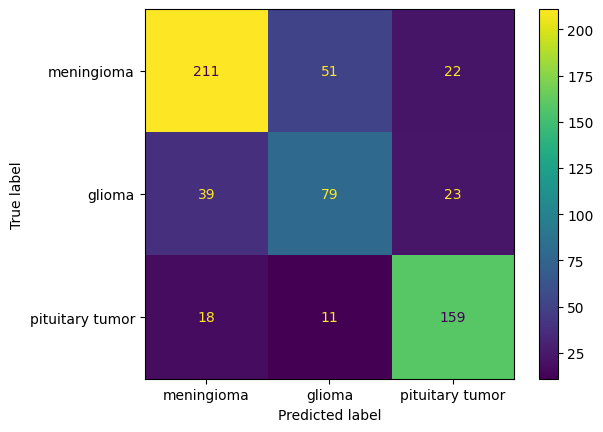

In [ ]:
#display Confusion Matrix
pred = trainer.predict(test_dataset)

cm_display = met.ConfusionMatrixDisplay(confusion_matrix = compute_metrics(pred), display_labels = labels_names)

cm_display.plot()
plt.show()

#EfficientFormer

###Import and create model

In [13]:
from transformers import EfficientFormerForImageClassification
from transformers import AutoImageProcessor

# define the EfficientFormer Model
def model_init():
  model = EfficientFormerForImageClassification.from_pretrained("snap-research/efficientformer-l1-300")
  model.config.label2id = {tumor_type: i for i, tumor_type in enumerate(labels_names)}
  model.config.num_labels = len(labels_names)
  model.config.id2label = {str(i): tumor_type for i, tumor_type in enumerate(labels_names)}
  return model

##Create Transforms

In [9]:
torch.cuda.empty_cache()
# Define the augmentation pipeline with imgaug
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip with probability of 0.5
    iaa.Sometimes(0.3, iaa.GaussianBlur((0, 1.0))),  # apply Gaussian blur with probability of 0.3
    iaa.Sometimes(0.5, iaa.SaltAndPepper(0.05)),  # Add Salt and Pepper noise with probability of 0.5
    iaa.Sometimes(0.3, iaa.AdditivePoissonNoise(lam=(0, 30))),  # Add Poisson noise with probability of 0.3
])

# imgaug works with numpy images (HWC) but torchvision with PIL images, so we have to convert
imgaug_transform = Lambda(lambda img: augmenter.augment_image(np.array(img)))

# Define transformations for the train dataset (without augmentation)
train_transforms_without_aug = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

# Define transformations for the train dataset (including augmentation)
train_transforms_with_aug = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    imgaug_transform,
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

# Define transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),  # Resize 512x512 images to 224x224 using bilinear interpolation
    transforms.ToTensor(),  # Convert image to PyTorch tensor and automatically rescale to [0,1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image tensor to range [-1,1]
])

## Without Augmentation

In [10]:
#This needs to be re-defined when the notebook is this long:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [11]:
# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_without_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms)

In [18]:
# Initialize a new run

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_vit_no_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=15,
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)

Some weights of the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing EfficientFormerForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
wandb.init(project="eff_vit_with_aug")
#Train model:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
wandb.finish()

wandb: Currently logged in as: litvingil (deep_bekeif). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing EfficientFormerForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disab

Step,Training Loss,Validation Loss,Accuracy
50,0.497700,1.165688,0.649266
100,0.426300,0.329744,0.882545
150,0.221000,0.308642,0.903752
200,0.197200,0.184380,0.960848
250,0.166100,0.507530,0.838499
300,0.057100,0.495160,0.897227
350,0.024100,0.116779,0.977162
400,0.002900,0.345643,0.949429
450,0.025400,0.251672,0.959217
500,0.019300,0.119560,0.977162


Step,Training Loss,Validation Loss,Accuracy
50,0.497700,1.165688,0.649266
100,0.426300,0.329744,0.882545
150,0.221000,0.308642,0.903752
200,0.197200,0.184380,0.960848
250,0.166100,0.507530,0.838499
300,0.057100,0.495160,0.897227
350,0.024100,0.116779,0.977162
400,0.002900,0.345643,0.949429
450,0.025400,0.251672,0.959217
500,0.019300,0.119560,0.977162


***** train metrics *****
  epoch                    =        15.0
  total_flos               = 366175246GF
  train_loss               =      0.0792
  train_runtime            =  0:14:48.86
  train_samples_per_second =      41.362
  train_steps_per_second   =       2.599


eval/accuracy,▁▆▆▇▅▆█▇████████████████████████████████
eval/loss,█▃▃▂▄▄▁▂▁▁▂▁▁▁▂▁▁▂▂▂▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▃▄▇▂▅▆▂▄▂█▃▅▅▄▂▅▆▁▆▃▅▂▄▆▂▆▁▆▃▅▆▂▇▆▅▁▅▁▄▆
eval/samples_per_second,▆▅▂▇▃▃▇▅▇▁▆▄▄▅▇▄▃█▃▆▄▇▄▃▇▃█▃▆▃▃▇▂▃▄█▄█▅▃
eval/steps_per_second,▆▅▂▇▃▃▇▅▇▁▆▄▄▅▇▄▃█▃▆▄▇▅▃▇▃█▃▆▃▃▇▂▃▄█▄█▅▃
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


## With Augmentation

In [20]:
# Load the datasets from folders and process the dataset with the transform
train_dataset = ImageFolder(data_path + '/brain_dataset/train', transform=train_transforms_with_aug)
test_dataset = ImageFolder(data_path + '/brain_dataset/test', transform=test_transforms)

In [21]:
# Initialize a new run

# Define the TrainingArguments
training_args = TrainingArguments(
  output_dir=output_vit_no_aug,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=15,
  fp16=True,
  save_steps=100,#100
  eval_steps=50,#100
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
  seed = seed
)


trainer = Trainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator= lambda samples: {'pixel_values': torch.stack([sample[0] for sample in samples]),
                                   'labels': torch.tensor([sample[1] for sample in samples])},
)

Some weights of the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing EfficientFormerForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
wandb.init(project="eff_vit_with_aug")
#Train model:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
wandb.finish()

Some weights of the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing EfficientFormerForImageClassification: ['distillation_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EfficientFormerForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disab

Step,Training Loss,Validation Loss,Accuracy
50,0.520500,0.653517,0.787928
100,0.498200,0.269240,0.910277
150,0.332700,0.560298,0.817292
200,0.195800,0.319811,0.893964
250,0.324300,0.201889,0.923328
300,0.200900,0.265060,0.923328
350,0.262600,0.291674,0.920065
400,0.118300,0.097557,0.959217
450,0.132900,0.211417,0.941272
500,0.069200,0.105135,0.973899


Step,Training Loss,Validation Loss,Accuracy
50,0.520500,0.653517,0.787928
100,0.498200,0.269240,0.910277
150,0.332700,0.560298,0.817292
200,0.195800,0.319811,0.893964
250,0.324300,0.201889,0.923328
300,0.200900,0.265060,0.923328
350,0.262600,0.291674,0.920065
400,0.118300,0.097557,0.959217
450,0.132900,0.211417,0.941272
500,0.069200,0.105135,0.973899


***** train metrics *****
  epoch                    =        15.0
  total_flos               = 366175246GF
  train_loss               =      0.1281
  train_runtime            =  0:17:18.24
  train_samples_per_second =      35.411
  train_steps_per_second   =       2.225


eval/accuracy,▁▅▂▅▆▆▆▆█▇▇██▇▇▇▇▇▇██▇██████████████████
eval/loss,█▃▇▄▃▃▄▃▁▂▂▁▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▂▂▁▂▁▃▂▃▂▃▃▂▄▃▃▂▂▂▃▂▃▁▂▂▁█▂▃▂▃▄▂▂▂▃▂▃▂▂
eval/samples_per_second,█▇▇█▇█▆▇▆▇▅▆▇▅▆▆▇▇▇▆▇▆█▇▆█▁▆▆▇▆▅▇▆▇▅▇▆▇▇
eval/steps_per_second,█▇▇█▇█▆▇▆▇▅▆▇▅▆▆▇▇▇▆▇▆█▇▆█▁▆▆▇▆▅▇▆▇▅▇▆▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
